In [2]:
from sqlalchemy import create_engine,select,cast,Numeric,func,Table, MetaData,inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
import pandas as pd




Q1: What is the price distribution of menu items?


In [3]:
DATABASE_URL = 'sqlite:///../databases/deliveroo.db'
engine = create_engine(DATABASE_URL)
Base = automap_base()
Base.prepare(engine, reflect=True)
menu = Base.classes.menu_items
Session = sessionmaker(bind=engine)
session = Session()
df=pd.read_sql_query(sql=select(menu.name,cast(menu.price,Numeric(10,2))), con=engine)
print(df.head())

C:\Users\rasmi\AppData\Local\Temp\ipykernel_25956\2447457913.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


                               name  price
0                             Rijst    3.5
1        Vegi boot (1 pers - 25 st)   25.0
2                   Crunchy chicken   17.5
3                     zalm hosomaki    7.0
4  Groenten tikka masala met paneer   14.5


In [4]:
df.describe()

,price
count,292038.000000
mean,6.056445
std,9.972373
min,-12.500000
25%,1.000000
50%,3.500000
75%,8.500000
max,2000.000000


Text(0.5, 1.0, 'Price Distribution for Deliveroo')

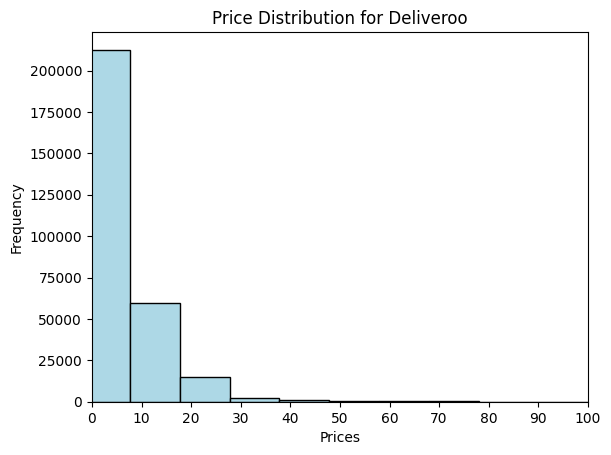

In [6]:
import matplotlib.pyplot as plt

p=plt.hist(df['price'], color='lightblue', edgecolor='black',bins=200)
plt.xlim(0,100)
plt.xticks(range(0, 101, 10))
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title('Price Distribution for Deliveroo')

In [7]:
DATABASE_URL = 'sqlite:///../databases/takeaway.db'
engine = create_engine(DATABASE_URL)
Base = automap_base()
Base.prepare(engine, reflect=True)
menu = Base.classes.menuItems
Session = sessionmaker(bind=engine)
session = Session()
dft=pd.read_sql_query(sql=select(menu.name,cast(menu.price,Numeric(10,2))), con=engine)
print(dft.head())

C:\Users\rasmi\AppData\Local\Temp\ipykernel_25956\1977376529.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


             name  price
0      Hummus dip   6.95
1    Seasonal dip   6.95
2        BarBacon  12.95
3     Chick(p)ita  13.95
4  Steak Republic  14.95


In [8]:
dft.describe()

,price
count,403013.000000
mean,9.973233
std,8.384140
min,0.000000
25%,4.000000
50%,9.000000
75%,13.950000
max,150.000000


Text(0.5, 1.0, 'Price Distribution for Takeaway')

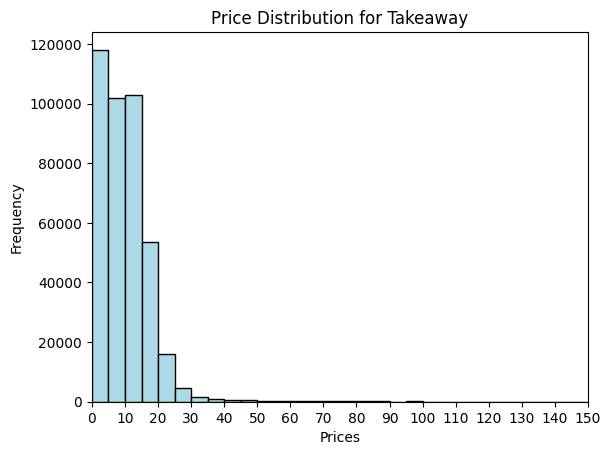

In [10]:
import matplotlib.pyplot as plt

p=plt.hist(dft['price'], color='lightblue', edgecolor='black',bins=30)
plt.xlim(0,150)
plt.xticks(range(0, 151, 10))
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title('Price Distribution for Takeaway')

Observations:
1. The price field is not a numeric type, cast it to perform analysis and visualization
2. There are negative values for price in the Deliveroo database which point to exclusions or removals from a standard menu item.

Question 5: Compare restaurant distributions across UberEats, Deliveroo, and Takeaway. What are some of the market trends?

In [11]:
def get_total_count(DATABASE_URL):
    engine = create_engine(DATABASE_URL)
    Base = automap_base()
    Base.prepare(engine, reflect=True)
    restaurants = Base.classes.restaurants
    Session = sessionmaker(bind=engine)
    session = Session()
    count=session.query(restaurants).count()
    return count

deliveroo=get_total_count('sqlite:///../databases/deliveroo.db')
takeaway=get_total_count('sqlite:///../databases/takeaway.db')


C:\Users\rasmi\AppData\Local\Temp\ipykernel_25956\2553985841.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
from sqlalchemy import Table, MetaData,inspect
DATABASE_URL = 'sqlite:///../databases/ubereats.db'
metadata = MetaData()
engine = create_engine(DATABASE_URL)
inspector = inspect(engine)
Session = sessionmaker(bind=engine)
session = Session()

table_list = inspector.get_table_names()
uber={}
for tabel in table_list:
    uber[tabel] =   Table(f'{tabel}', metadata, autoload_with=engine).c

r=uber['restaurants']
ubereats = session.query(r).count()


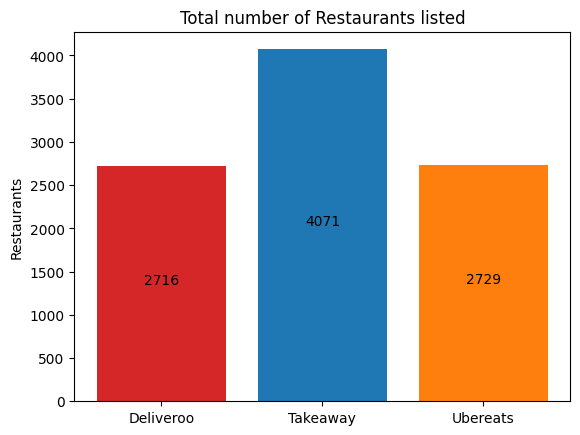

In [13]:
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

fig, ax = plt.subplots()

x = ['Deliveroo', 'Takeaway', 'Ubereats']
y = [deliveroo, takeaway, ubereats]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(x, y, color=bar_colors)

addlabels(x, y)

ax.set_ylabel('Restaurants')
ax.set_title('Total number of Restaurants listed')

plt.show()

Questions/Observations about Q5
Going in the direction of categories- to find one that is well liked. Calculating confidence of the rating stored is going to be a challenge. 
Solved by adding weights to number of ratings and the actual rating




-- SQL for takeaway

SELECT 
c.category_id as category, AVG(r.ratings) as avg_rating,AVG(r.ratingsNumber)as avg_number_of_ratings
FROM 
restaurants AS r JOIN categories_restaurants as c ON r.primarySlug= c.restaurant_id
GROUP BY 
c.category_id
ORDER BY
AVG(r.ratings) DESC

In [14]:
#Function that gets all tables from a db
def get_tables_from_db(DATABASE_URL):
    metadata = MetaData()
    engine = create_engine(DATABASE_URL)
    inspector = inspect(engine)
    table_list = inspector.get_table_names()
    db={}
    for tabel in table_list:
        db[tabel] =   Table(f'{tabel}', metadata, autoload_with=engine)

    return db,engine

In [15]:
print(takeaway)

4071


In [16]:
DATABASE_URL = 'sqlite:///../databases/takeaway.db'

takeaway,engine=get_tables_from_db(DATABASE_URL)
CategoryRestaurant=takeaway['categories_restaurants']
Restaurant=takeaway['restaurants']

Session = sessionmaker(bind=engine)
session = Session()

query = (
session.query(
CategoryRestaurant.c.category_id.label('category'),
func.avg(Restaurant.c.ratings).label('avg_rating'),
func.avg(Restaurant.c.ratingsNumber).label('avg_number_of_ratings')
)
.join(Restaurant, Restaurant.c.primarySlug == CategoryRestaurant.c.restaurant_id)
.group_by(CategoryRestaurant.c.category_id)
.having(func.avg(Restaurant.c.ratingsNumber)>100)
.order_by(func.avg(Restaurant.c.ratings).desc())
)


df=pd.read_sql(query.statement,query.session.bind)
df['adjustedRating'] = df['avg_rating']*0.3 + df['avg_number_of_ratings']*0.7
sorted_df = df.sort_values(by='adjustedRating',ascending=False)
takeaway_top= sorted_df.head(5)

SQL for Deliveroo

SELECT category, AVG(rating) as Average_Rating, AVG(rating_number) as Average_No_Ratings from restaurants GROUP BY category ORDER BY AVG(rating) DESC 

In [17]:
DATABASE_URL = 'sqlite:///../databases/deliveroo.db'
deliveroodb,engine=get_tables_from_db(DATABASE_URL)
Restaurant=deliveroodb['restaurants']
Session = sessionmaker(bind=engine)
session = Session()
query = (
session.query(
Restaurant.c.category,
func.avg(Restaurant.c.rating).label('avg_rating'),
func.avg(Restaurant.c.rating_number).label('avg_number_of_ratings')
)
.group_by(Restaurant.c.category)
.having(func.avg(Restaurant.c.rating_number)>100)
.order_by(func.avg(Restaurant.c.rating).desc())
)

df=pd.read_sql(query.statement,query.session.bind)
df['adjustedRating'] = df['avg_rating']*0.3 + df['avg_number_of_ratings']*0.7
sorted_df = df.sort_values(by='adjustedRating',ascending=False)
deliveroo_top=sorted_df.head(5)

SQL  for uber eats

SELECT 
c.category, AVG(r.rating__rating_value) as avg_rating,AVG(r.rating__review_count) as avg_number_of_ratings 
FROM 
restaurants AS r JOIN restaurant_to_categories as c ON r.id= c.restaurant_id 
GROUP BY 
c.category
ORDER BY
AVG(r.rating__rating_value) DESC



In [18]:
DATABASE_URL='sqlite:///../databases/ubereats.db'
ubereatsdb,engine=get_tables_from_db(DATABASE_URL)
Restaurant=ubereatsdb['restaurants']
RestaurantToCategory=ubereatsdb['restaurant_to_categories']
Session = sessionmaker(bind=engine)
session = Session()

query = (
session.query(
RestaurantToCategory.c.category,
func.avg(Restaurant.c.rating__rating_value).label('avg_rating'),
func.avg(Restaurant.c.rating__review_count).label('avg_number_of_ratings')
)
.join(Restaurant, Restaurant.c.id == RestaurantToCategory.c.restaurant_id)
.group_by(RestaurantToCategory.c.category)
.having(func.avg(Restaurant.c.rating__review_count)>100)
.order_by(func.avg(Restaurant.c.rating__rating_value).desc())
)
df=pd.read_sql(query.statement,query.session.bind)
df['adjustedRating'] = df['avg_rating']*0.3 + df['avg_number_of_ratings']*0.7
sorted_df = df.sort_values(by='adjustedRating',ascending=False)
ubereats_top=sorted_df.head(5)

In [19]:
deliveroo_top

,category,avg_rating,avg_number_of_ratings,adjustedRating
12,Fries,4.222222,406.222222,285.622222
3,Israeli,4.566667,370.333333,260.603333
17,Poke,3.545000,321.600000,226.183500
15,French Tacos,4.000000,258.333333,182.033333
0,Foodball Deals 😋,4.700000,254.000000,179.210000


In [20]:
ubereats_top

,category,avg_rating,avg_number_of_ratings,adjustedRating
5,StreetÂ food,4.5,200.0,141.35
9,AmÃ©rique latine (fusion),4.5,200.0,141.35
10,Poulet frit,4.3,183.0,129.39
14,TexÂ Mex,3.4,157.0,110.92
1,Bols,4.7,146.0,103.61


In [21]:
takeaway_top

,category,avg_rating,avg_number_of_ratings,adjustedRating
12,american-pizza_281,3.909863,782.830137,549.154055
11,chinese_41,3.921348,656.387640,460.647753
18,2600,3.795939,598.510152,420.095888
15,italian-pizza_271,3.845126,553.091195,388.317374
14,pita-kebab_651,3.856628,517.490698,363.400477


In [57]:
import plotly.express as px
#Function that plots the bar graph
def plot_top_categories(df,name):
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 500,
        'width': 900,
        'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    fig = px.bar(df, x='category', y='avg_rating',
                hover_data=['avg_rating','avg_number_of_ratings'], color='category',
                title=f'Top 5 categories in {name}',
                labels={'avg_rating':'Rating','category':'Category'}
                )
    fig.update_traces(showlegend=False) 
    fig.update_layout( xaxis={'categoryorder':'total descending'},title_x=0.5)

    fig.show(config=config)


In [60]:

plot_top_categories(takeaway_top,"Take Away")

In [61]:
plot_top_categories(ubereats_top,"Uber Eats")

In [58]:
plot_top_categories(ubereats_top,"Deliveroo")

Where are the most vegetarian and vegan restaurants?


-- SQLite takeaway
SELECT 
DISTINCT (r.name )as Restaurant_Name,r.latitude,r.longitude,r.city
FROM 
restaurants AS r JOIN menuItems as m ON r.primarySlug= m.primarySlug
WHERE
m.name like '%veg%'

In [31]:
from sqlalchemy import distinct
DATABASE_URL = 'sqlite:///../databases/takeaway.db'
takeawaydb,engine=get_tables_from_db(DATABASE_URL)
Restaurant=takeawaydb['restaurants']
MenuItem=takeawaydb['menuItems']
Session = sessionmaker(bind=engine)
session = Session()
query = session.query(
distinct(Restaurant.c.name).label('Restaurant_Name'),
Restaurant.c.latitude,
Restaurant.c.longitude,
).join(MenuItem, Restaurant.c.primarySlug == MenuItem.c.primarySlug
).filter(MenuItem.c.name.like('%veg%'))

takeaway_veg=pd.read_sql(query.statement,query.session.bind)


-- SQLite ubereats
SELECT
DISTINCT(r.title) as Restaurant_Name, r.location__city as city,r.location__latitude as latitude,r.location__longitude as longitude
FROM
restaurants r JOIN menu_items m on r.id=m.restaurant_id
WHERE
m.name LIKE '%veg%'

In [32]:

DATABASE_URL = 'sqlite:///../databases/ubereats.db'
ubereatsdb,engine=get_tables_from_db(DATABASE_URL)
Restaurant=ubereatsdb['restaurants']
MenuItem=ubereatsdb['menu_items']
Session = sessionmaker(bind=engine)
session = Session()
query = session.query(
distinct(Restaurant.c.title).label('Restaurant_Name'),
Restaurant.c.location__latitude.label('latitude'),
Restaurant.c.location__longitude.label('longitude')
).join(MenuItem, Restaurant.c.id == MenuItem.c.restaurant_id
).filter(MenuItem.c.name.like('%veg%'))

ubereats_veg=pd.read_sql(query.statement,query.session.bind)

-- SQLite deliveroo
SELECT
DISTINCT(r.name) as Restaurant_Name, r.latitude,r.longitude
FROM
restaurants r JOIN menu_items m on r.id=m.restaurant_id
WHERE
m.name like '%veg%'

In [35]:

DATABASE_URL = 'sqlite:///../databases/deliveroo.db'
deliveroodb,engine=get_tables_from_db(DATABASE_URL)
Restaurant=deliveroodb['restaurants']
MenuItem=deliveroodb['menu_items']
Session = sessionmaker(bind=engine)
session = Session()
query = session.query(
distinct(Restaurant.c.name).label('Restaurant_Name'),
Restaurant.c.latitude,
Restaurant.c.longitude,
).join(MenuItem, Restaurant.c.id == MenuItem.c.restaurant_id
).filter(MenuItem.c.name.like('%veg%'))

deliveroo_veg=pd.read_sql(query.statement,query.session.bind)

Plotting the vegetarian/vegan restaurants against a map

In [36]:
ubereats_veg['latitude'] = ubereats_veg['latitude'].astype('float64')
ubereats_veg['longitude'] = ubereats_veg['longitude'].astype('float64')
deliveroo_veg['latitude']= deliveroo_veg['latitude'].astype('float64')
deliveroo_veg['longitude']= deliveroo_veg['longitude'].astype('float64')
takeaway_veg['longitude']= takeaway_veg['longitude'].astype('float64')
takeaway_veg['latitude']= takeaway_veg['latitude'].astype('float64')
ubereats_veg['source']='ubereats'
deliveroo_veg['source']='deliveroo'
takeaway_veg['source']='takeaway'
veg_rest=pd.concat([ubereats_veg,deliveroo_veg,takeaway_veg])

In [ ]:
veg_rest.shape

(5710, 4)

In [56]:
import plotly.express as px
import plotly.graph_objects as go
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 700,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig = px.scatter_map(veg_rest, lat="latitude", lon="longitude",size_max=0.2,color="source",zoom=8, color_discrete_map={"ubereats": "navy", "deliveroo": "maroon","takeaway":"lightgreen"})
fig.update_traces(marker=dict(opacity=0.5))

fig.show(config=config)
